# STEMMUS_SCOPE & MODFLOW 6 BMI coupling

This Python notebook shows a simple example of BMI coupling between the STEMMUS_SCOPE model and the MODFLOW 6 model. The example is prepared for one of the PLUMBER2 dataset (https://researchdata.edu.au/plumber2-forcing-evaluation-surface-models/1656048): the LooBos site, the Netherlands (NL-Loo). To run this notebook, the following are required:
- Install the related packages:
    - pyStemmusScope package (https://pystemmusscope.readthedocs.io/en/latest/).
    - modflowapi Python package (https://github.com/MODFLOW-USGS/modflowapi?tab=readme-ov-file#installation).
- The executable files of both models. 
    - STEMMUS_SCOPE executable file can be retrieved from the link (https://github.com/EcoExtreML/STEMMUS_SCOPE/blob/main/run_model_on_snellius/exe/STEMMUS_SCOPE). Note: the STEMMUS_SCOPE executable file is Linux-based only.
    - MODFLOW 6 executable files can be retrieved from the link (https://github.com/MODFLOW-USGS/modflow6/releases). Note: This notebook is based on MODFLOW 6.5.0 (Linux version). 
- The input files of both models are already prepared in advance and are not part of this notebook. The input data files can be accessed via this link (https://zenodo.org/records/13354850). The link also includes a version of the executable files needed to run the models. Download, unzip and copy the folders to your own working directory (root directory, see below the cell under the header: *1. Set up the root directory*).
 
In case the user wants to test the notebook on another site, preparing input files for both models is required. Preparing input files for STEMMUS_SCOPE can be done through the PyStemmusScope Python package (https://pystemmusscope.readthedocs.io/en/latest/notebooks/run_model_on_different_infra/). Preparing input files for MODFLOW 6 can be done through the FloPy Python package (https://flopy.readthedocs.io/en/stable/tutorials.html#modflow-6).


Notes
- Units in STEMMUS_SCOPE are centimetres and seconds. The model runs every 30 mins.
- Units in MODFLOW 6 are meter and day. The model runs every day.
- STEMMUS_SCOPE runs per time steps.
- MODFLOW 6 runs per stress periods and time steps. A stress period is the period of time when the model forcing is fixed. Each stress period can be divided into a number of time steps. In each time step, model variables will be updated (but model forcing is still fixed).
- This example runs for 10 days. STEMMUS_SCOPE has 480 time steps (length of each time step = 30 mins). MODFLOW 6 has 10 stress periods (length of each period = 1 day and each period has 48 time steps), so in total MODFLOW 6 runs 480 times.

In [47]:
import os
import sys
import shutil
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from PyStemmusScope.config_io import read_config
from PyStemmusScope.bmi.implementation import StemmusScopeBmi
from modflowapi import ModflowApi
from modflowapi.extensions import ApiSimulation
from cftime import num2pydate
from rich import print

In [48]:
startTime = datetime.now()

### 1. Set up the root directory

In [49]:
root = os.path.join('.', 'SSM_examples', 'ex1') # the root path where all folders are stored into
executables_workspace = os.path.join('.', 'SSM_examples', 'executables')
output_figures_workspace = os.path.join(root, 'output_figures')
if not os.path.exists(output_figures_workspace):
    os.makedirs(output_figures_workspace)

#### 1.1. Set up STEMMUS_SCOPE folder and config file

In [50]:
stemmus_scope_workspace = os.path.join(root, 'stsc_input', 'NL-Loo_2024-08-12-1341')
stemmus_scope_config_file = os.path.join(stemmus_scope_workspace, "NL-Loo_2024-08-12-1341_config.txt")

If we are using the local executable file we first have to add the Matlab runtime compiler locations to PATH:

In [51]:
# Add the matlab runtime compiler locations: 
matlab_version = 'R2023a'
matlab_path = '/opt/matlab/MATLAB_Runtime/' + matlab_version 
 
os.environ['LD_LIBRARY_PATH'] = (   
    f"{matlab_path}/runtime/glnxa64:"
    f"{matlab_path}/bin/glnxa64:"
    f"{matlab_path}/sys/os/glnxa64:"
    f"{matlab_path}/extern/bin/glnxa64:"
    f"{matlab_path}/sys/opengl/lib/glnxa64")
print(os.environ['LD_LIBRARY_PATH'])
os.environ["STEMMUS_SCOPE"] = read_config(stemmus_scope_config_file)["ExeFilePath"]

/opt/matlab/MATLAB_Runtime/R2023a/runtime/glnxa64:/opt/matlab/MATLAB_Runtime/R2023a/bin/glnxa64:/opt/matlab/MATLAB_
Runtime/R2023a/sys/os/glnxa64:/opt/matlab/MATLAB_Runtime/R2023a/extern/bin/glnxa64:/opt/matlab/MATLAB_Runtime/R2023
a/sys/opengl/lib/glnxa64

#### 1.2. Set up MODFLOW 6 workspace and dll/so file

In [52]:
modflow_workspace = os.path.join(root, 'mf6_model_base')
modflow_exe_file = os.path.join(executables_workspace, "libmf6.so")  # for window -> "libmf6.dll"

### 2. Load and initialize models

#### 2.1. Initialize the STEMMUS_SCOPE model 

In [53]:
stemmus_scope = StemmusScopeBmi()
stemmus_scope.initialize(stemmus_scope_config_file)

##### Note: STEMMUS_SCOPE needs to be updated by one timestep before the BMI is accessible

In [54]:
stemmus_scope.update()

##### Define arrays to store the needed STEMMUS_SCOPE variables

In [55]:
n_timesteps = int((stemmus_scope.get_end_time() - stemmus_scope.get_current_time())/stemmus_scope.get_time_step())
n_soil_layers = stemmus_scope.get_grid_size(stemmus_scope.get_var_grid("soil_moisture"))

soil_moisture = np.zeros((n_timesteps, n_soil_layers))
soil_temperature = np.zeros((n_timesteps, n_soil_layers))
gw_recharge = np.zeros(1)
gw_recharge_nstp = np.array([])
stemmus_scope_time = []
i = 0

#### 2.2. Initialize the MODFLOW 6 model and get other settings

In [56]:
modflow = ModflowApi(modflow_exe_file, working_directory = modflow_workspace)
modflow_config_file = os.path.join(modflow_workspace, 'mfsim.nam')
modflow.initialize(modflow_config_file)

##### Load the MODFLOW 6 simulation and models

In [57]:
sim = ApiSimulation.load(modflow)
gwf_name = sim.model_names[0] # groundwater flow model 
gwe_name = sim.model_names[1] # groundwater energy (heat) model
gwf_name, gwe_name

('gwf', 'gwe')

##### Get number of stress periods (days) and time steps of MODFLOW

In [58]:
nper, nstp = sim.nper, sim.nstp
nper, nstp

(10, 48)

##### Get pointers of MODFLOW API data

In [59]:
top_tag = modflow.get_var_address("TOP", gwf_name.upper(), "DIS") # tag of land surface (top) elevation
gwhead_tag = modflow.get_var_address("X", gwf_name) # tag of groundwater heads
gwtemp_tag = modflow.get_var_address("X", gwe_name) # tag of groundwater temperature
rch_tag = modflow.get_var_address("RECHARGE", gwf_name.upper(), "RCH_0") # tag of groundwater recharge

##### Get Initial head and temperature of MODFLOW

In [60]:
top_elev = modflow.get_value(top_tag)[0] * 100 # multiply by 100 to convert from m to cm
gwhead_init = modflow.get_value(gwhead_tag)[0] * 100 # multiply by 100 to convert from m to cm
gwtemp_init = modflow.get_value(gwtemp_tag)[0]

gwhead_init, gwtemp_init, top_elev

(2350.0, 10.0, 2600.0)

##### Update MODFLOW 6 by one time step to match with the time step of STEMMUS_SCOPE

In [61]:
modflow.update()

### 3. Start STEMMUS_SCOPE & MODFLOW coupling

##### Enable groundwater coupling option in STEMMUS_SCOPE

In [62]:
stemmus_scope.set_value("groundwater_coupling_enabled", np.array([True]))

##### Set the MODFLOW 6 initial variables [Land surface elevation, groundwater initial head, and groundwater initial temperature (optional)] in STEMMUS_SCOPE

In [63]:
stemmus_scope.set_value("groundwater_elevation_top_aquifer", top_elev)
stemmus_scope.set_value("groundwater_head_bottom_layer", gwhead_init)
stemmus_scope.set_value("groundwater_temperature", gwtemp_init) 

##### Iterate through the time steps of both models and exchange variables.

For every time step of STEMMUS_SCOPE:
- MODFLOW 6 gives groundwater head and groundwater temperature to STEMMUS_SCOPE

For every stress period of MODFLOW 6 (which has 48 time steps of MODFLOW 6):
- STEMMUS_SCOPE gives groundwater recharge to MODFLOW 6 (recharge_stress_period = sum of 48 recharge_time_step)

In [64]:
while modflow.get_current_time() < modflow.get_end_time():
    while stemmus_scope.get_current_time() < stemmus_scope.get_end_time(): 
        
        # Get STEMMUS_SCOPE variables (soil moisture, soil temperature, groundwater recharge)  
        stemmus_scope.get_value("soil_moisture", soil_moisture[i])
        stemmus_scope.get_value("soil_temperature", soil_temperature[i])
        stemmus_scope.get_value("groundwater_recharge", gw_recharge)
        gw_recharge_nstp = np.append(gw_recharge_nstp, gw_recharge)

        # Store the current time as a datetime
        stemmus_scope_time.append(num2pydate(stemmus_scope.get_current_time(), stemmus_scope.get_time_units()))
        i+= 1

        # Get MODFLOW 6 variables (groundwater head, groundwater temperature)
        gwhead = modflow.get_value(gwhead_tag)[0] * 100
        gwtemp = modflow.get_value(gwtemp_tag)[0]

        # Set STEMMUS_SCOPE variables (groundwater head, groundwater temperature)
        stemmus_scope.set_value("groundwater_head_bottom_layer", gwhead)
        stemmus_scope.set_value("groundwater_temperature", gwtemp)
        
        # Set MODFLOW 6 variables (groundwater recharge)
        kstp, kper = sim.kstp, sim.kper     
        if kstp == nstp - 1:
            # groundwater recharge per stress period = sum of groundwater recharge per time step 
            gw_recharge_nper = np.array([-1 * np.sum(gw_recharge_nstp) / 100]) # multiply by -1 due to different signs of both models
            modflow.set_value(rch_tag, gw_recharge_nper)
            gw_recharge_nstp = np.array([]) 
             
        # Track the simulation time of MODFLOW 6  
        print('Updating MODFLOW Stress period ' + str(kper + 1) + ', time step ' + str(kstp + 1))
        # print(kper  + 1, kstp + 1, gwhead, gwtemp)
       
        # Update models
        stemmus_scope.update()
        modflow.update()

Updating MODFLOW Stress period 1, time step 1

Updating MODFLOW Stress period 1, time step 2

Updating MODFLOW Stress period 1, time step 3

Updating MODFLOW Stress period 1, time step 4

Updating MODFLOW Stress period 1, time step 5

Updating MODFLOW Stress period 1, time step 6

Updating MODFLOW Stress period 1, time step 7

Updating MODFLOW Stress period 1, time step 8

Updating MODFLOW Stress period 1, time step 9

Updating MODFLOW Stress period 1, time step 10

Updating MODFLOW Stress period 1, time step 11

Updating MODFLOW Stress period 1, time step 12

Updating MODFLOW Stress period 1, time step 13

Updating MODFLOW Stress period 1, time step 14

Updating MODFLOW Stress period 1, time step 15

Updating MODFLOW Stress period 1, time step 16

Updating MODFLOW Stress period 1, time step 17

Updating MODFLOW Stress period 1, time step 18

Updating MODFLOW Stress period 1, time step 19

Updating MODFLOW Stress period 1, time step 20

Updating MODFLOW Stress period 1, time step 21

Updating MODFLOW Stress period 1, time step 22

Updating MODFLOW Stress period 1, time step 23

Updating MODFLOW Stress period 1, time step 24

Updating MODFLOW Stress period 1, time step 25

Updating MODFLOW Stress period 1, time step 26

Updating MODFLOW Stress period 1, time step 27

Updating MODFLOW Stress period 1, time step 28

Updating MODFLOW Stress period 1, time step 29

Updating MODFLOW Stress period 1, time step 30

Updating MODFLOW Stress period 1, time step 31

Updating MODFLOW Stress period 1, time step 32

Updating MODFLOW Stress period 1, time step 33

Updating MODFLOW Stress period 1, time step 34

Updating MODFLOW Stress period 1, time step 35

Updating MODFLOW Stress period 1, time step 36

Updating MODFLOW Stress period 1, time step 37

Updating MODFLOW Stress period 1, time step 38

Updating MODFLOW Stress period 1, time step 39

Updating MODFLOW Stress period 1, time step 40

Updating MODFLOW Stress period 1, time step 41

Updating MODFLOW Stress period 1, time step 42

Updating MODFLOW Stress period 1, time step 43

Updating MODFLOW Stress period 1, time step 44

Updating MODFLOW Stress period 1, time step 45

Updating MODFLOW Stress period 1, time step 46

Updating MODFLOW Stress period 1, time step 47

Updating MODFLOW Stress period 1, time step 48

Updating MODFLOW Stress period 2, time step 1

Updating MODFLOW Stress period 2, time step 2

Updating MODFLOW Stress period 2, time step 3

Updating MODFLOW Stress period 2, time step 4

Updating MODFLOW Stress period 2, time step 5

Updating MODFLOW Stress period 2, time step 6

Updating MODFLOW Stress period 2, time step 7

Updating MODFLOW Stress period 2, time step 8

Updating MODFLOW Stress period 2, time step 9

Updating MODFLOW Stress period 2, time step 10

Updating MODFLOW Stress period 2, time step 11

Updating MODFLOW Stress period 2, time step 12

Updating MODFLOW Stress period 2, time step 13

Updating MODFLOW Stress period 2, time step 14

Updating MODFLOW Stress period 2, time step 15

Updating MODFLOW Stress period 2, time step 16

Updating MODFLOW Stress period 2, time step 17

Updating MODFLOW Stress period 2, time step 18

Updating MODFLOW Stress period 2, time step 19

Updating MODFLOW Stress period 2, time step 20

Updating MODFLOW Stress period 2, time step 21

Updating MODFLOW Stress period 2, time step 22

Updating MODFLOW Stress period 2, time step 23

Updating MODFLOW Stress period 2, time step 24

Updating MODFLOW Stress period 2, time step 25

Updating MODFLOW Stress period 2, time step 26

Updating MODFLOW Stress period 2, time step 27

Updating MODFLOW Stress period 2, time step 28

Updating MODFLOW Stress period 2, time step 29

Updating MODFLOW Stress period 2, time step 30

Updating MODFLOW Stress period 2, time step 31

Updating MODFLOW Stress period 2, time step 32

Updating MODFLOW Stress period 2, time step 33

Updating MODFLOW Stress period 2, time step 34

Updating MODFLOW Stress period 2, time step 35

Updating MODFLOW Stress period 2, time step 36

Updating MODFLOW Stress period 2, time step 37

Updating MODFLOW Stress period 2, time step 38

Updating MODFLOW Stress period 2, time step 39

Updating MODFLOW Stress period 2, time step 40

Updating MODFLOW Stress period 2, time step 41

Updating MODFLOW Stress period 2, time step 42

Updating MODFLOW Stress period 2, time step 43

Updating MODFLOW Stress period 2, time step 44

Updating MODFLOW Stress period 2, time step 45

Updating MODFLOW Stress period 2, time step 46

Updating MODFLOW Stress period 2, time step 47

Updating MODFLOW Stress period 2, time step 48

Updating MODFLOW Stress period 3, time step 1

Updating MODFLOW Stress period 3, time step 2

Updating MODFLOW Stress period 3, time step 3

Updating MODFLOW Stress period 3, time step 4

Updating MODFLOW Stress period 3, time step 5

Updating MODFLOW Stress period 3, time step 6

Updating MODFLOW Stress period 3, time step 7

Updating MODFLOW Stress period 3, time step 8

Updating MODFLOW Stress period 3, time step 9

Updating MODFLOW Stress period 3, time step 10

Updating MODFLOW Stress period 3, time step 11

Updating MODFLOW Stress period 3, time step 12

Updating MODFLOW Stress period 3, time step 13

Updating MODFLOW Stress period 3, time step 14

Updating MODFLOW Stress period 3, time step 15

Updating MODFLOW Stress period 3, time step 16

Updating MODFLOW Stress period 3, time step 17

Updating MODFLOW Stress period 3, time step 18

Updating MODFLOW Stress period 3, time step 19

Updating MODFLOW Stress period 3, time step 20

Updating MODFLOW Stress period 3, time step 21

Updating MODFLOW Stress period 3, time step 22

Updating MODFLOW Stress period 3, time step 23

Updating MODFLOW Stress period 3, time step 24

Updating MODFLOW Stress period 3, time step 25

Updating MODFLOW Stress period 3, time step 26

Updating MODFLOW Stress period 3, time step 27

Updating MODFLOW Stress period 3, time step 28

Updating MODFLOW Stress period 3, time step 29

Updating MODFLOW Stress period 3, time step 30

Updating MODFLOW Stress period 3, time step 31

Updating MODFLOW Stress period 3, time step 32

Updating MODFLOW Stress period 3, time step 33

Updating MODFLOW Stress period 3, time step 34

Updating MODFLOW Stress period 3, time step 35

Updating MODFLOW Stress period 3, time step 36

Updating MODFLOW Stress period 3, time step 37

Updating MODFLOW Stress period 3, time step 38

Updating MODFLOW Stress period 3, time step 39

Updating MODFLOW Stress period 3, time step 40

Updating MODFLOW Stress period 3, time step 41

Updating MODFLOW Stress period 3, time step 42

Updating MODFLOW Stress period 3, time step 43

Updating MODFLOW Stress period 3, time step 44

Updating MODFLOW Stress period 3, time step 45

Updating MODFLOW Stress period 3, time step 46

Updating MODFLOW Stress period 3, time step 47

Updating MODFLOW Stress period 3, time step 48

Updating MODFLOW Stress period 4, time step 1

Updating MODFLOW Stress period 4, time step 2

Updating MODFLOW Stress period 4, time step 3

Updating MODFLOW Stress period 4, time step 4

Updating MODFLOW Stress period 4, time step 5

Updating MODFLOW Stress period 4, time step 6

Updating MODFLOW Stress period 4, time step 7

Updating MODFLOW Stress period 4, time step 8

Updating MODFLOW Stress period 4, time step 9

Updating MODFLOW Stress period 4, time step 10

Updating MODFLOW Stress period 4, time step 11

Updating MODFLOW Stress period 4, time step 12

Updating MODFLOW Stress period 4, time step 13

Updating MODFLOW Stress period 4, time step 14

Updating MODFLOW Stress period 4, time step 15

Updating MODFLOW Stress period 4, time step 16

Updating MODFLOW Stress period 4, time step 17

Updating MODFLOW Stress period 4, time step 18

Updating MODFLOW Stress period 4, time step 19

Updating MODFLOW Stress period 4, time step 20

Updating MODFLOW Stress period 4, time step 21

Updating MODFLOW Stress period 4, time step 22

Updating MODFLOW Stress period 4, time step 23

Updating MODFLOW Stress period 4, time step 24

Updating MODFLOW Stress period 4, time step 25

Updating MODFLOW Stress period 4, time step 26

Updating MODFLOW Stress period 4, time step 27

Updating MODFLOW Stress period 4, time step 28

Updating MODFLOW Stress period 4, time step 29

Updating MODFLOW Stress period 4, time step 30

Updating MODFLOW Stress period 4, time step 31

Updating MODFLOW Stress period 4, time step 32

Updating MODFLOW Stress period 4, time step 33

Updating MODFLOW Stress period 4, time step 34

Updating MODFLOW Stress period 4, time step 35

Updating MODFLOW Stress period 4, time step 36

Updating MODFLOW Stress period 4, time step 37

Updating MODFLOW Stress period 4, time step 38

Updating MODFLOW Stress period 4, time step 39

Updating MODFLOW Stress period 4, time step 40

Updating MODFLOW Stress period 4, time step 41

Updating MODFLOW Stress period 4, time step 42

Updating MODFLOW Stress period 4, time step 43

Updating MODFLOW Stress period 4, time step 44

Updating MODFLOW Stress period 4, time step 45

Updating MODFLOW Stress period 4, time step 46

Updating MODFLOW Stress period 4, time step 47

Updating MODFLOW Stress period 4, time step 48

Updating MODFLOW Stress period 5, time step 1

Updating MODFLOW Stress period 5, time step 2

Updating MODFLOW Stress period 5, time step 3

Updating MODFLOW Stress period 5, time step 4

Updating MODFLOW Stress period 5, time step 5

Updating MODFLOW Stress period 5, time step 6

Updating MODFLOW Stress period 5, time step 7

Updating MODFLOW Stress period 5, time step 8

Updating MODFLOW Stress period 5, time step 9

Updating MODFLOW Stress period 5, time step 10

Updating MODFLOW Stress period 5, time step 11

Updating MODFLOW Stress period 5, time step 12

Updating MODFLOW Stress period 5, time step 13

Updating MODFLOW Stress period 5, time step 14

Updating MODFLOW Stress period 5, time step 15

Updating MODFLOW Stress period 5, time step 16

Updating MODFLOW Stress period 5, time step 17

Updating MODFLOW Stress period 5, time step 18

Updating MODFLOW Stress period 5, time step 19

Updating MODFLOW Stress period 5, time step 20

Updating MODFLOW Stress period 5, time step 21

Updating MODFLOW Stress period 5, time step 22

Updating MODFLOW Stress period 5, time step 23

Updating MODFLOW Stress period 5, time step 24

Updating MODFLOW Stress period 5, time step 25

Updating MODFLOW Stress period 5, time step 26

Updating MODFLOW Stress period 5, time step 27

Updating MODFLOW Stress period 5, time step 28

Updating MODFLOW Stress period 5, time step 29

Updating MODFLOW Stress period 5, time step 30

Updating MODFLOW Stress period 5, time step 31

Updating MODFLOW Stress period 5, time step 32

Updating MODFLOW Stress period 5, time step 33

Updating MODFLOW Stress period 5, time step 34

Updating MODFLOW Stress period 5, time step 35

Updating MODFLOW Stress period 5, time step 36

Updating MODFLOW Stress period 5, time step 37

Updating MODFLOW Stress period 5, time step 38

Updating MODFLOW Stress period 5, time step 39

Updating MODFLOW Stress period 5, time step 40

Updating MODFLOW Stress period 5, time step 41

Updating MODFLOW Stress period 5, time step 42

Updating MODFLOW Stress period 5, time step 43

Updating MODFLOW Stress period 5, time step 44

Updating MODFLOW Stress period 5, time step 45

Updating MODFLOW Stress period 5, time step 46

Updating MODFLOW Stress period 5, time step 47

Updating MODFLOW Stress period 5, time step 48

Updating MODFLOW Stress period 6, time step 1

Updating MODFLOW Stress period 6, time step 2

Updating MODFLOW Stress period 6, time step 3

Updating MODFLOW Stress period 6, time step 4

Updating MODFLOW Stress period 6, time step 5

Updating MODFLOW Stress period 6, time step 6

Updating MODFLOW Stress period 6, time step 7

Updating MODFLOW Stress period 6, time step 8

Updating MODFLOW Stress period 6, time step 9

Updating MODFLOW Stress period 6, time step 10

Updating MODFLOW Stress period 6, time step 11

Updating MODFLOW Stress period 6, time step 12

Updating MODFLOW Stress period 6, time step 13

Updating MODFLOW Stress period 6, time step 14

Updating MODFLOW Stress period 6, time step 15

Updating MODFLOW Stress period 6, time step 16

Updating MODFLOW Stress period 6, time step 17

Updating MODFLOW Stress period 6, time step 18

Updating MODFLOW Stress period 6, time step 19

Updating MODFLOW Stress period 6, time step 20

Updating MODFLOW Stress period 6, time step 21

Updating MODFLOW Stress period 6, time step 22

Updating MODFLOW Stress period 6, time step 23

Updating MODFLOW Stress period 6, time step 24

Updating MODFLOW Stress period 6, time step 25

Updating MODFLOW Stress period 6, time step 26

Updating MODFLOW Stress period 6, time step 27

Updating MODFLOW Stress period 6, time step 28

Updating MODFLOW Stress period 6, time step 29

Updating MODFLOW Stress period 6, time step 30

Updating MODFLOW Stress period 6, time step 31

Updating MODFLOW Stress period 6, time step 32

Updating MODFLOW Stress period 6, time step 33

Updating MODFLOW Stress period 6, time step 34

Updating MODFLOW Stress period 6, time step 35

Updating MODFLOW Stress period 6, time step 36

Updating MODFLOW Stress period 6, time step 37

Updating MODFLOW Stress period 6, time step 38

Updating MODFLOW Stress period 6, time step 39

Updating MODFLOW Stress period 6, time step 40

Updating MODFLOW Stress period 6, time step 41

Updating MODFLOW Stress period 6, time step 42

Updating MODFLOW Stress period 6, time step 43

Updating MODFLOW Stress period 6, time step 44

Updating MODFLOW Stress period 6, time step 45

Updating MODFLOW Stress period 6, time step 46

Updating MODFLOW Stress period 6, time step 47

Updating MODFLOW Stress period 6, time step 48

Updating MODFLOW Stress period 7, time step 1

Updating MODFLOW Stress period 7, time step 2

Updating MODFLOW Stress period 7, time step 3

Updating MODFLOW Stress period 7, time step 4

Updating MODFLOW Stress period 7, time step 5

Updating MODFLOW Stress period 7, time step 6

Updating MODFLOW Stress period 7, time step 7

Updating MODFLOW Stress period 7, time step 8

Updating MODFLOW Stress period 7, time step 9

Updating MODFLOW Stress period 7, time step 10

Updating MODFLOW Stress period 7, time step 11

Updating MODFLOW Stress period 7, time step 12

Updating MODFLOW Stress period 7, time step 13

Updating MODFLOW Stress period 7, time step 14

Updating MODFLOW Stress period 7, time step 15

Updating MODFLOW Stress period 7, time step 16

Updating MODFLOW Stress period 7, time step 17

Updating MODFLOW Stress period 7, time step 18

Updating MODFLOW Stress period 7, time step 19

Updating MODFLOW Stress period 7, time step 20

Updating MODFLOW Stress period 7, time step 21

Updating MODFLOW Stress period 7, time step 22

Updating MODFLOW Stress period 7, time step 23

Updating MODFLOW Stress period 7, time step 24

Updating MODFLOW Stress period 7, time step 25

Updating MODFLOW Stress period 7, time step 26

Updating MODFLOW Stress period 7, time step 27

Updating MODFLOW Stress period 7, time step 28

Updating MODFLOW Stress period 7, time step 29

Updating MODFLOW Stress period 7, time step 30

Updating MODFLOW Stress period 7, time step 31

Updating MODFLOW Stress period 7, time step 32

Updating MODFLOW Stress period 7, time step 33

Updating MODFLOW Stress period 7, time step 34

Updating MODFLOW Stress period 7, time step 35

Updating MODFLOW Stress period 7, time step 36

Updating MODFLOW Stress period 7, time step 37

Updating MODFLOW Stress period 7, time step 38

Updating MODFLOW Stress period 7, time step 39

Updating MODFLOW Stress period 7, time step 40

Updating MODFLOW Stress period 7, time step 41

Updating MODFLOW Stress period 7, time step 42

Updating MODFLOW Stress period 7, time step 43

Updating MODFLOW Stress period 7, time step 44

Updating MODFLOW Stress period 7, time step 45

Updating MODFLOW Stress period 7, time step 46

Updating MODFLOW Stress period 7, time step 47

Updating MODFLOW Stress period 7, time step 48

Updating MODFLOW Stress period 8, time step 1

Updating MODFLOW Stress period 8, time step 2

Updating MODFLOW Stress period 8, time step 3

Updating MODFLOW Stress period 8, time step 4

Updating MODFLOW Stress period 8, time step 5

Updating MODFLOW Stress period 8, time step 6

Updating MODFLOW Stress period 8, time step 7

Updating MODFLOW Stress period 8, time step 8

Updating MODFLOW Stress period 8, time step 9

Updating MODFLOW Stress period 8, time step 10

Updating MODFLOW Stress period 8, time step 11

Updating MODFLOW Stress period 8, time step 12

Updating MODFLOW Stress period 8, time step 13

Updating MODFLOW Stress period 8, time step 14

Updating MODFLOW Stress period 8, time step 15

Updating MODFLOW Stress period 8, time step 16

Updating MODFLOW Stress period 8, time step 17

Updating MODFLOW Stress period 8, time step 18

Updating MODFLOW Stress period 8, time step 19

Updating MODFLOW Stress period 8, time step 20

Updating MODFLOW Stress period 8, time step 21

Updating MODFLOW Stress period 8, time step 22

Updating MODFLOW Stress period 8, time step 23

Updating MODFLOW Stress period 8, time step 24

Updating MODFLOW Stress period 8, time step 25

Updating MODFLOW Stress period 8, time step 26

Updating MODFLOW Stress period 8, time step 27

Updating MODFLOW Stress period 8, time step 28

Updating MODFLOW Stress period 8, time step 29

Updating MODFLOW Stress period 8, time step 30

Updating MODFLOW Stress period 8, time step 31

Updating MODFLOW Stress period 8, time step 32

Updating MODFLOW Stress period 8, time step 33

Updating MODFLOW Stress period 8, time step 34

Updating MODFLOW Stress period 8, time step 35

Updating MODFLOW Stress period 8, time step 36

Updating MODFLOW Stress period 8, time step 37

Updating MODFLOW Stress period 8, time step 38

Updating MODFLOW Stress period 8, time step 39

Updating MODFLOW Stress period 8, time step 40

Updating MODFLOW Stress period 8, time step 41

Updating MODFLOW Stress period 8, time step 42

Updating MODFLOW Stress period 8, time step 43

Updating MODFLOW Stress period 8, time step 44

Updating MODFLOW Stress period 8, time step 45

Updating MODFLOW Stress period 8, time step 46

Updating MODFLOW Stress period 8, time step 47

Updating MODFLOW Stress period 8, time step 48

Updating MODFLOW Stress period 9, time step 1

Updating MODFLOW Stress period 9, time step 2

Updating MODFLOW Stress period 9, time step 3

Updating MODFLOW Stress period 9, time step 4

Updating MODFLOW Stress period 9, time step 5

Updating MODFLOW Stress period 9, time step 6

Updating MODFLOW Stress period 9, time step 7

Updating MODFLOW Stress period 9, time step 8

Updating MODFLOW Stress period 9, time step 9

Updating MODFLOW Stress period 9, time step 10

Updating MODFLOW Stress period 9, time step 11

Updating MODFLOW Stress period 9, time step 12

Updating MODFLOW Stress period 9, time step 13

Updating MODFLOW Stress period 9, time step 14

Updating MODFLOW Stress period 9, time step 15

Updating MODFLOW Stress period 9, time step 16

Updating MODFLOW Stress period 9, time step 17

Updating MODFLOW Stress period 9, time step 18

Updating MODFLOW Stress period 9, time step 19

Updating MODFLOW Stress period 9, time step 20

Updating MODFLOW Stress period 9, time step 21

Updating MODFLOW Stress period 9, time step 22

Updating MODFLOW Stress period 9, time step 23

Updating MODFLOW Stress period 9, time step 24

Updating MODFLOW Stress period 9, time step 25

Updating MODFLOW Stress period 9, time step 26

Updating MODFLOW Stress period 9, time step 27

Updating MODFLOW Stress period 9, time step 28

Updating MODFLOW Stress period 9, time step 29

Updating MODFLOW Stress period 9, time step 30

Updating MODFLOW Stress period 9, time step 31

Updating MODFLOW Stress period 9, time step 32

Updating MODFLOW Stress period 9, time step 33

Updating MODFLOW Stress period 9, time step 34

Updating MODFLOW Stress period 9, time step 35

Updating MODFLOW Stress period 9, time step 36

Updating MODFLOW Stress period 9, time step 37

Updating MODFLOW Stress period 9, time step 38

Updating MODFLOW Stress period 9, time step 39

Updating MODFLOW Stress period 9, time step 40

Updating MODFLOW Stress period 9, time step 41

Updating MODFLOW Stress period 9, time step 42

Updating MODFLOW Stress period 9, time step 43

Updating MODFLOW Stress period 9, time step 44

Updating MODFLOW Stress period 9, time step 45

Updating MODFLOW Stress period 9, time step 46

Updating MODFLOW Stress period 9, time step 47

Updating MODFLOW Stress period 9, time step 48

Updating MODFLOW Stress period 10, time step 1

Updating MODFLOW Stress period 10, time step 2

Updating MODFLOW Stress period 10, time step 3

Updating MODFLOW Stress period 10, time step 4

Updating MODFLOW Stress period 10, time step 5

Updating MODFLOW Stress period 10, time step 6

Updating MODFLOW Stress period 10, time step 7

Updating MODFLOW Stress period 10, time step 8

Updating MODFLOW Stress period 10, time step 9

Updating MODFLOW Stress period 10, time step 10

Updating MODFLOW Stress period 10, time step 11

Updating MODFLOW Stress period 10, time step 12

Updating MODFLOW Stress period 10, time step 13

Updating MODFLOW Stress period 10, time step 14

Updating MODFLOW Stress period 10, time step 15

Updating MODFLOW Stress period 10, time step 16

Updating MODFLOW Stress period 10, time step 17

Updating MODFLOW Stress period 10, time step 18

Updating MODFLOW Stress period 10, time step 19

Updating MODFLOW Stress period 10, time step 20

Updating MODFLOW Stress period 10, time step 21

Updating MODFLOW Stress period 10, time step 22

Updating MODFLOW Stress period 10, time step 23

Updating MODFLOW Stress period 10, time step 24

Updating MODFLOW Stress period 10, time step 25

Updating MODFLOW Stress period 10, time step 26

Updating MODFLOW Stress period 10, time step 27

Updating MODFLOW Stress period 10, time step 28

Updating MODFLOW Stress period 10, time step 29

Updating MODFLOW Stress period 10, time step 30

Updating MODFLOW Stress period 10, time step 31

Updating MODFLOW Stress period 10, time step 32

Updating MODFLOW Stress period 10, time step 33

Updating MODFLOW Stress period 10, time step 34

Updating MODFLOW Stress period 10, time step 35

Updating MODFLOW Stress period 10, time step 36

Updating MODFLOW Stress period 10, time step 37

Updating MODFLOW Stress period 10, time step 38

Updating MODFLOW Stress period 10, time step 39

Updating MODFLOW Stress period 10, time step 40

Updating MODFLOW Stress period 10, time step 41

Updating MODFLOW Stress period 10, time step 42

Updating MODFLOW Stress period 10, time step 43

Updating MODFLOW Stress period 10, time step 44

Updating MODFLOW Stress period 10, time step 45

Updating MODFLOW Stress period 10, time step 46

Updating MODFLOW Stress period 10, time step 47

#### Finalize models

In [65]:
modflow.finalize()
stemmus_scope.finalize()

### 4. Export results

##### Analyze the STEMMUS_SCOPE variables (put the data into xarray DataArray objects)

In [66]:
gs = stemmus_scope.get_grid_size(1)
depths = np.ones(gs)
stemmus_scope.get_grid_z(1, depths)

da_sm = xr.DataArray(
    data=soil_moisture,
    dims=("time", "depth"),
    coords={"time": np.array(stemmus_scope_time), "depth": depths},)

da_t = xr.DataArray(
    data=soil_temperature,
    dims=("time", "depth"),
    coords={"time": np.array(stemmus_scope_time), "depth": depths},)

##### Show the STEMMUS_SCOPE soil moisture and soil temperature results

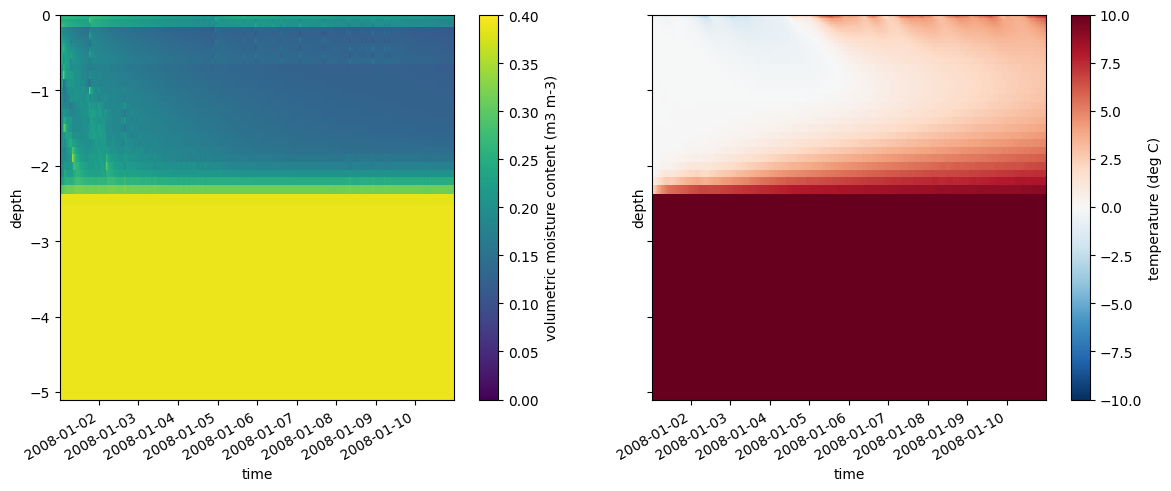

In [67]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14,5))
ax1.set_title("Soil Moisture")
ax2.set_title("Soil Temperature")
ax1.set_ylabel("depth (m)")
ax2.set_ylabel("depth (m)")
da_sm.plot(y="depth", ax=ax1, cbar_kwargs={'label': "volumetric moisture content (m3 m-3)"})
da_t.plot(y="depth", ax=ax2, cbar_kwargs={'label': "temperature (deg C)"})
fig.savefig(os.path.join(output_figures_workspace, 'soil_variables.png'), dpi = 600, bbox_inches = 'tight')

In [68]:
print ('the script took', datetime.now() - startTime, 'to run')

the script took 0:05:39.729457 to run